HEADER BAR DOES NOT WORK WITH QUARTO, ACCESS OTHER TABS BY CLOSING THIS ONE

# Introduction

Public transportation as a whole has to deal with the natural elements, whether it be traversing difficult terrain, battling constantly changing weather phenomena, and the natural erosion of the components of transportation equipment, among others. This is espcially true for the New York City Subway System, where hundreds of stations are above ground$^1$, along with over a dozen tunnels underneath rivers, combined with divergent temperature extrema throughout the year (high 90s in the summer compared to 20s in the winter in Fahrenheit). The impact of these innumerable natural elements is important to evaluate to see what phenomena may pose significant challenges towards the efficiency and safety of the NYC Subway System. One way NYC Subway performance is assessed is through a metric known as mean distance between failures (MDBF), which measures, in miles, the average distance travelled by subway trains before a "failure" or breakdown occurs.$^2$. These data span from January 2015 to August 2022, and encompasses the average MDBF of the NYC subway fleet on a monthly basis. This is juxtaposed with two indicators of weather phenomena, being the average maximum daily temperature (in Fahrenheit) and average daily precipitation (in inches), which thousands of subway train cars are subject to on a daily basis. The measurements for these two variables are extracted from the NOAA. Temperature maximum is used as average daily temperatures were not available to be extracted from the NOAA for the date range in question. To investigate this connection, various clustering methods will be performed using these three variables: MDBF, temperature maximum, and precipitation

# What is Clustering and How Does It Work?

Clustering encompasses a subset of unsupervised machine learning algorithms that aims to group an unlabelled set of data points into some number of clusters (i.e., subgroups of data points), often with goal of unearthing previously unseen patterns in the data that can be investigated further. Since these data must be unlabeled (i.e., no reference category or variable that is being predicted is present), clustering models are not usually constructed to have predictive power, unlike supervised methods such as Naive Bayes and Support Vector Machines used earlier in this project, among others. Specifically, clustering algorithms aim to group data points together based on some sort of distance metric (i.e., how "far apart" data points are from one each other) such that elements within a cluster as alike as possible while maximizing the difference between them and other clusters. There are countless different methods that may be used to cluster data, ranging in mathematical and visual complexity. I will make use of three notable clustering algorithms: K-Means, DBSCAN, and hierarchical clustering.

### K-Means

K-Means clustering is one of the most well-known and frequently used clustering algorithms, and it aims to partition data points based on centroids. Centroids are, as the name implies, the approximate center of each created cluster. When a K-Means model is created, each data point is assigned to a centroid based on a distance metric (i.e., way of measuring distance between data points based on variables) which minimizes the distances of points within a given cluster to its given centroid while maximizing the distances of those points to those in other clusters. However, these centroids are not present in the underlying data that is being subjected to clustering analysis, they are instead determined by initial random guesses (centroids are placed randomly within the data set), and then are adjusted in accordance with an algorithm such as Lloyd's or Elkan's Algorithm (more information on these at https://www.vlfeat.org/api/kmeans-fundamentals.html). Once these centroids are fully readjusted, one should expect/hope for clearly delineated and separable clusters with minimal/no overlap. However, there are countless different ways that a K-Means model can be constructed, based on various user defined inputs (hyperparameters), which must be altered and adjusted to find the most optimal model for the scenario at hand (model selection).

The number of centroids in K-Means clustering is a user-defined hyperparameter. This determines the number of clusters the data will be partitioned into, and thus it is paramount to find the optimal value of this parameter for a successful and useful model to be devised. To find the ideal value for this hyperparameter, one must construct a model for a user defined set of number of clusters to be tested, and evaluate each of them in comparison to one another. This is accomplished through the elbow and silhouette methods, which are utilized in this project. These are covered more in depth as they are used in the sections to come of this tab.

### DBSCAN

DBSCAN, or density-based spatial clustering of applications with noise, is another partitioning clustering algorithm (i.e., like k-means), which aims to partition data points into groups based on the density of data points in given areas within a given overall data set. This method is particularly useful when analyzing data which appear to have irregularly shaped clusters and/or when there are many outliers present (hence the "noise" in DBSCAN). When the DBSCAN algorithm is applied to a given data set, data points that lie close together (calculated using a distance metric) are denoted as being part of a particular cluster, while data points that lie far away from the main sections of a data set are often denoted as outliers, or "noise." Like K-Means, there are hyparameters that need to be configured in order to select the most optimal model for the data set at hand.

One notable hyperparameter for DBSCAN is epsilon (denoted as eps in sklearn), which denotes the maximum distance such that a given point is considered near enough to another point to be considered a "neighbor" to be grouped into the same cluster. In other words, as the epsilon value is increased, each data point considers a larger "area" to be its "neighborhood" where data points therein may be part of the same cluster, resulting in larger/more expansive clusters. Another important hyparameter for DBSCAN modeling is the minimum samples parameter (denoted as min_samples in sklearn), which defines the number of data points around a given data point that are within its epsilon-based "neighborhood" such that that individual data point is a "core point." A core point is usually within the interior of a cluster, with many other points nearby. This is juxtaposed with border points, which are at the edge of a given cluster, which, while lying within the epsilon "neighborhood" of the cluster at-large, do not have as many points nearby as  core points. Different variations in these two parameters will be analyzed using silhouette scores, which are covered more in depth in the sections to come. For more information on the hyperparameters for the DBSCAN algorithm, please see the accompanying documentation: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html.

### Hierarchical Clustering

Hierarchical clustering (HC), unlike DBSCAN and k-means, does not aim to partition a data set into nonoverlapping clusters, instead opting to create a nested structure of clusters, creating a structure somewhat similar in shape to the decision trees constructed earlier in this project. There are two main characterizations of hierarchical clustering, each two sides of the same coin: agglomerative and division. Agglomerative HC begins the tree-like structure, known as a dendrogram, from the bottom-up, where each individual data point is its own little cluster, building up recursively to include nearby data points, eventually resulting in one huge cluster encompassing the whole data set at the top of the dendrogram. Division HC works in the opposite manner, breaking down the overall data set from one large cluster into smaller and smaller clusters until each data point has its own individual cluster. For this project in particular, only an agglomerative clustering will be used. Like the partition based models, hierarchical clustering models also require a model selection process, along with hyperparameter tuning of its own.

The paramount parameters to be determined for HC analysis are the number of clusters to be created and the linkage method when adding up distance metrics. A linkage method is the means by which distance metrics between data points are aggregated and compared to one another to form the splits and joins of the resulting dendrograms. Both of these parameters may be optimized by looking at the dendrograms for each linkage method being considered. Specific linkage methods will be covered in more depth as they are tested later in this document. Additionally, the method as to determine what is the apparent most optimal number of clusters will also be discussed later in this document. The search space of possible linkage methods and number of clusters is large, so this project will deal with five linkage methods: Ward's, UPGMA, WPGMA, complete, and single. All of these will be briefly introduced later in this document.



# Methods

## Data Preprocessing

Before the weather and the mean distance between failures data sets may be appropriate for clustering analysis, they must be modified and merged together, and the code that accomplishes this task is attached at the top of this page. The MDBF data set includes monthly averages of mean distance between failures (in miles) across the entire NYC Subway fleet of railcars (as cleaned in the Data Cleaning section of this project), while the weather data set includes daily measurements of various characteristics of the local weather in New York City. In order for these two data sets to be merged, they must both be on the same time scale, in this case monthly averages. To accomplish this, for the weather characteristics of interest (precipitation and temperature maximum), monthly averages were calculated and summarized in a new data frame, containing the month in question, and their respective monthly averages for precipitation and temperature maximum. These fall in line with the monthly averages for MDBF present in its respective data set. These two modified dataframes were merged together, and this subsequent data set serves as the subject for the subsequent clustering analyses. Additionally, these data were normalized to optimize the speed of the performance of the subsequent clustering algorithms.

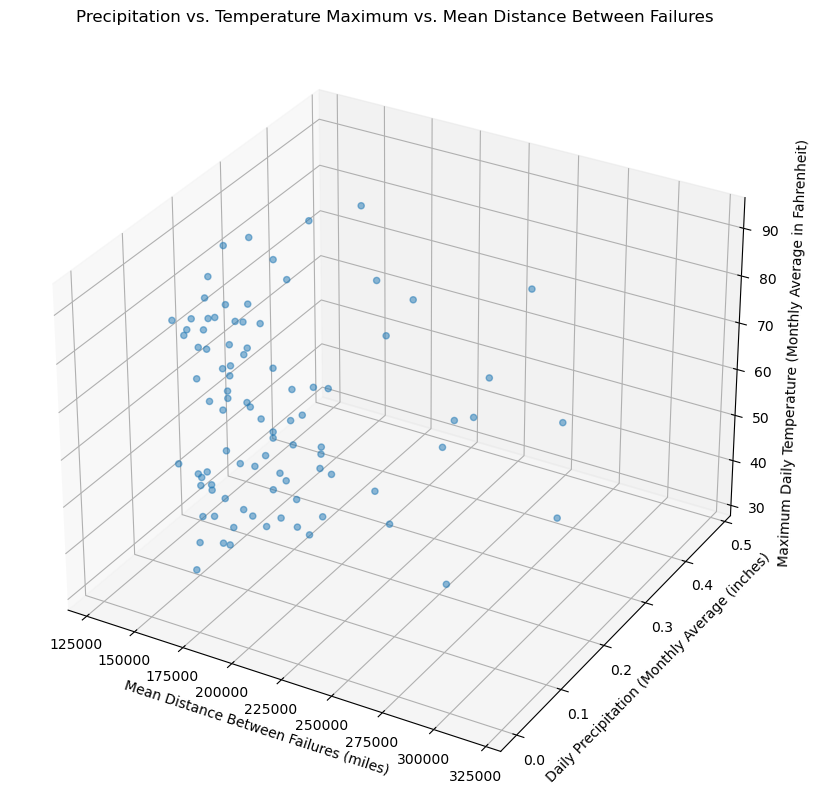

In [2]:
# Necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch
import sklearn.cluster as cluster
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MeanShift
from sklearn.cluster import Birch
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import MinMaxScaler

# Read in data files
weather = pd.read_csv("../../data/01-modified-data/NYC-Weather-Data-Cleaned.csv",index_col=0)
mdbf = pd.read_csv("../../data/01-modified-data/MDBF-Cleaned-Merged.csv",index_col=0)

# Join files by date, create monthly averages to make joining possible
mdbf['ServiceDate'] = pd.to_datetime(mdbf['ServiceDate'])
mdbf = mdbf.groupby(pd.PeriodIndex(mdbf['ServiceDate'],freq='M'))['mdbf'].mean().reset_index()
weather['DATE'] = pd.to_datetime(weather['DATE'])
mean_weather = weather.groupby(pd.PeriodIndex(weather['DATE'],freq='M'))[['PRCP','TMAX']].mean().reset_index()
mean_weather = mean_weather.rename(columns={'DATE':"ServiceDate"})

# merge dfs
df = mdbf.merge(mean_weather,on=['ServiceDate'])
# Variable selection
X = np.array(df.drop(columns='ServiceDate'))

# Plot initial data values
# Plot clusters
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2],alpha=0.5)
ax.set_title("Precipitation vs. Temperature Maximum vs. Mean Distance Between Failures")
ax.set_xlabel("Mean Distance Between Failures (miles)")
ax.set_zlabel("Maximum Daily Temperature (Monthly Average in Fahrenheit)")
ax.set_ylabel("Daily Precipitation (Monthly Average (inches)")
plt.savefig("../../501-project-website/images/CLUSTERING-INIT-SCATTER.png")
plt.show()

# Normalize data 
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)


The above scatterplot shows the MDBF, daily precipitation, and maximum daily temperature for each month encompassed in the data set (January 2015-August 2022). There appears to be some dispersion in the data suggesting that clustering analyses may be useful towards examining this data set, given by the large clump of data to the near left with a scattering of points to the right and above it. Thus, these data will be subjected to the three clustering methods outlined earlier in this section. First, k-means clustering will be applied.

# KMeans Clustering

## Hyperparameter Tuning

### Elbow Method

To perform hyperparameter tuning for k-means clustering to assess the appropriate "k" value (number of centroids) for these data, both the elbow method and silhouette scores were used. The elbow method will be explained here and in the section below. To accomplish this, several models were fitted to the data set using different values of k (in this case, ranging from 1 to 10), and their respective distortions and inertias were measured and compared against one another. Distortion is the average of the sum of the squared distances between each point and its respective assigned centroid, while inertia is simply the sum of the squared distances of sample points to their nearby cluster center. The distortion and inertia for the model for each "k" value are found and plotted using the code below.

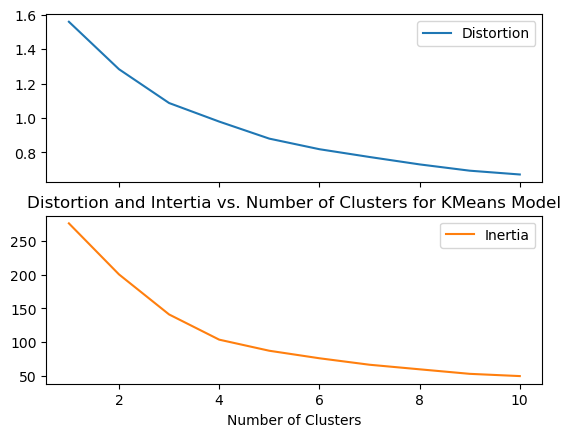

In [10]:
# Test multiple k values using ELBOW method
# Code adapted from ANLY501 lab-5.2 authored by Alex Pattarini
dists = []
inertias = []

k = 11
for k in range(1,k):
    model = KMeans(n_clusters=k,init='k-means++',random_state=0)
    model.fit(X)
    dists.append(sum(np.min(cdist(X,model.cluster_centers_,'euclidean'),axis=1))/X.shape[0])
    inertias.append(model.inertia_)
    df = pd.DataFrame({'Cluster Num':np.arange(1,k+1), 'Distortion':dists, 'Inertia':inertias})

df.plot.line(x='Cluster Num',subplots=True)
plt.title("Distortion and Intertia vs. Number of Clusters for KMeans Model")
plt.xlabel("Number of Clusters")
plt.savefig("../../501-project-website/images/CLUSTERING-KM-HPTUNING.png")
plt.show()


The above graphs depict the number of clusters compared to the distortion and inertia for k-means models applied to these data. The aptly named elbow method involves finding the crook of the elbow shaped graphs above, which designate the most optimal number of clusters according to this method. In the plots above, it is apparent that approximately three or four clusters are the optimal number for this data set with regards to k-means clustering. However, this is not the only means to assess which k value is ideal for k-means clustering, analysis of silhouette scores are calculated and visualized in the next section of this document.

### Silhouette Analysis

Silhouette analysis is another means as to assessing the effectiveness of many clustering models, including k-means. Silhouette scores measure inter-cluster variation, where each data point has its distance relative to points in other clusters evaluated, and scores range from -1 to 1, where 1 represents very high separation to other clusters, while a 0 indicates that a given point is near the borders between clusters. As different "k" values are tested, the average silhouette scores of all points in each model are calculated, stored, and compared against one another to assess which number of centroids maximizes inter-cluster separation (which we want to maxmimize as outlined earlier). The silhouette scores for the 10 different tested k values are plotted below.

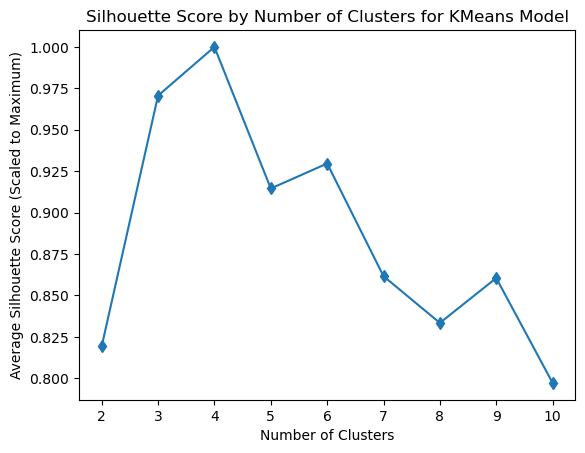

In [11]:
# Code partially adapted from Professor James Hickman's 3D-SKLEARN-CLUSTERING-EXAMPLE.py
silhouette_scores = []
n_clusters = []
for n_cluster in range(2,11):
    model = KMeans(n_clusters=n_cluster,init='k-means++',random_state=0)
    model_labels = model.fit_predict(X)
    sil_score = silhouette_score(X, model_labels)
    silhouette_scores.append(sil_score)
    n_clusters.append(n_cluster)

n_clusters=np.array(n_clusters)
silhouette_scores=np.array(silhouette_scores)
plt.plot(n_clusters,silhouette_scores/np.max(silhouette_scores), '-d')
plt.xlabel("Number of Clusters")
plt.ylabel("Average Silhouette Score (Scaled to Maximum)")
plt.title("Silhouette Score by Number of Clusters for KMeans Model")
plt.savefig("../../501-project-website/images/CLUSTERING-KM-HPTUNING-SIL.png")
plt.show()
    

The plot above shows the relative silhouette average scores for the models associated with their respective number of clusters. These averages are scaled such that the model with the largest average silhouette score is assigned a value of 1, and the other models' average silhouette scores are scaled relative to that maximum. In the plot above, the model that assigns the data to four clusters has the highest average silhouette score, with the three cluster model not far behind. Thus, considering the results of the elbow method outlined earlier as well as the silhouette scores calculated above, the final model that will be fitted to these data will have a "k" value of 4, meaning the data will be assigned to 4 clusters around 4 centroids. That model and further analyses are depicted below.

## Results of KMeans Clustering

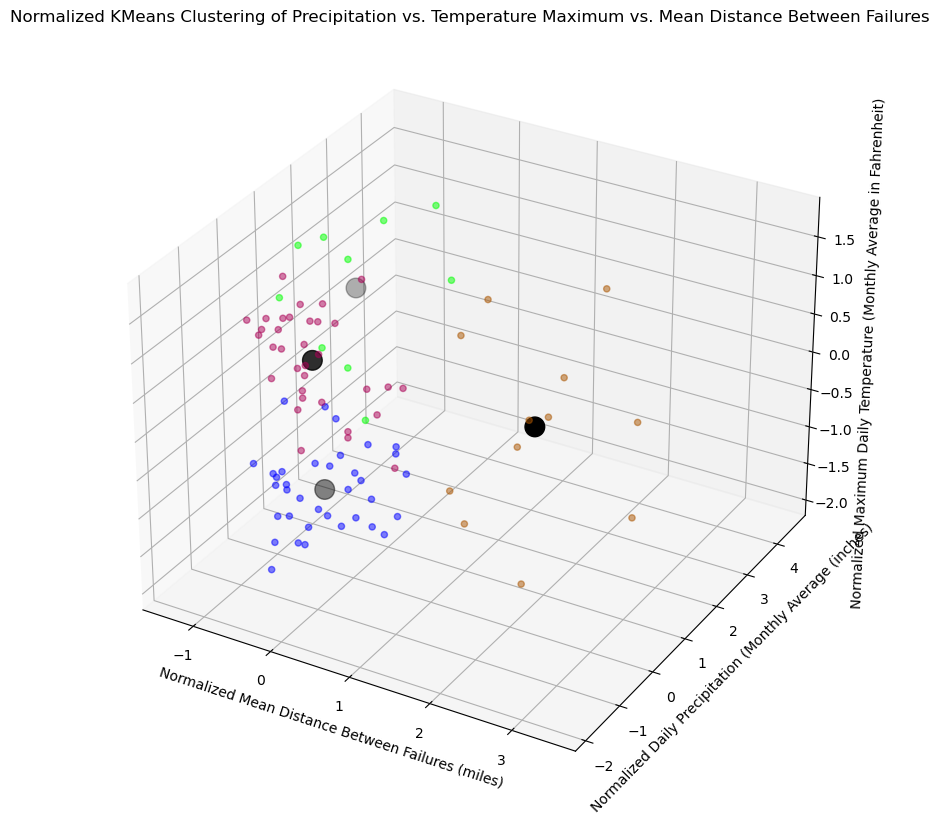

In [12]:
# Final model
model = KMeans(n_clusters=4,init='k-means++',random_state=0).fit(X)
y_kmeans = model.predict(X)
centroids = model.cluster_centers_

# Plot clusters/centroids
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2],c=y_kmeans, cmap='brg',alpha=0.5)
ax.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1],model.cluster_centers_[:,2], s=200, c='black')
ax.set_title("Normalized KMeans Clustering of Precipitation vs. Temperature Maximum vs. Mean Distance Between Failures")
ax.set_xlabel("Normalized Mean Distance Between Failures (miles)")
ax.set_zlabel("Normalized Maximum Daily Temperature (Monthly Average in Fahrenheit)")
ax.set_ylabel("Normalized Daily Precipitation (Monthly Average (inches)")
plt.savefig("../../501-project-website/images/CLUSTERING-KM-RESULTS.png")
plt.show()

A scatterplot of the clusters resulting from the k=4 k-means clustering model are pictured above. We can see, given the depth of the centroids in the graph given by their opacity (darker=closer to the viewer), that this model does a decent job at separating these data into delineated and separate clusters. The blue cluster includes values that are have low MDBF, average daily precipitation, and low maximum temperature. The brown cluster, on the other hand, primarily includes months with high MDBF with low precipitation and variable maximum daily temperatures. The green cluster seems to encompass the majority of the high average precipitation months, and tends to have relatively low MDBF with variable temperature maximums. Finally, the red/purple cluster includes samples with low precipitation (given by the nearness of the centroid), low MDBF, and variable maximum temperatures. Overall, the k-means model appears to do a solid job at separating these data into clusters. However, k-means clustering is not the only way that clustering may be applied to these data, so the DBSCAN algorithm is applied in the section below.

# DBScan Clustering

## Hyperparameter Tuning

As described earlier in this document, the primary two hyperparameters that were tuned for these data were the epsilon and minimum samples parameters. Since the DBSCAN algorithm does not generate centroids as k-means does, applying the elbow method with regard to distortion and inertia is not possible, so only the evaluation of the average silhouette scores was undertaken, and the code that accomplishes this task is presented below. The below section of code tests numerous different potential DBSCAN models, with tested epsilon values varying from 0.1 to 6.0 and minimum sample values ranging from 2 to 21, meaning a wide variety of potential models were tested and compared to one another. These results are calculated and summarized below. Any models that reuslt in only one cluster are disregarded as, regardless of their silhouette score, are not interesting or useful in any way (one cluster for all the data is not useful). Only models that result in two or more clusters are considered in this analysis.

BASED ON SILHOUETTE SCORES CALCULATED ABOVE:
The best number of clusters is: 2
The best eps value is: 1.289915966386555
The best min_samples value is: 6.0
With a silhouette score of: 0.3625135635952267


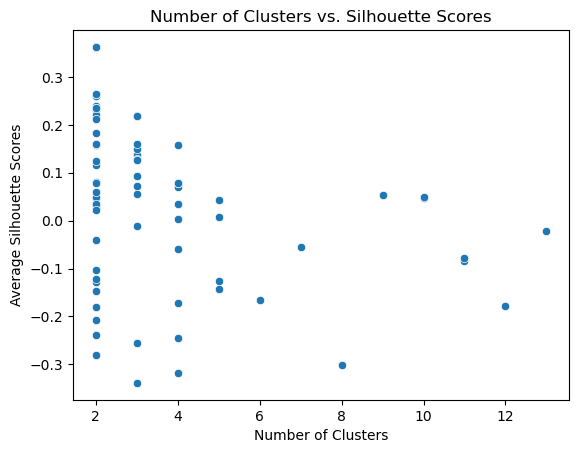

In [13]:
# Code adapted from ANLY501 lab-5.2 authored by Alex Pattarini
test_eps = np.linspace(0.1,6,120)
test_min_samples = np.linspace(2,21,20)

sil_scores = []
clusters_nums = []
best_sil_score = -1

for ep in test_eps:
    for min_sample in test_min_samples:
        try:
            model = DBSCAN(eps=ep,min_samples=int(min_sample)).fit(X)
            labels = model.labels_
            #print(labels)
            # Silhouette score
            sil_score = silhouette_score(X,labels)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0) # Adapted from https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html
            n_noise = list(labels).count(-1)
            # 1 cluster is a trivial solution, so any models that result in a 1 cluster solution are disregarded
            if n_clusters != 1:
                sil_scores.append(sil_score)
                clusters_nums.append(n_clusters)
                # If this sil score is better than prior scores, save info of best eps and min sample
                if sil_score > best_sil_score:
                    best_sil_score = sil_score
                    best_eps = ep
                    best_min_samples = min_sample
                    best_n_clusters = n_clusters
            #print(n_clusters)
            #print("SUCCESS")
        except:
            # Parameter test is invalid/produces unusable output (either too many or too few clusters)
            a=1
# Plot of silhouette score vs num clusters
#clusters_nums=np.array(clusters_nums)
#sil_scores=np.array(sil_scores)
# Plot of silhouette score vs num clusters
print("BASED ON SILHOUETTE SCORES CALCULATED ABOVE:")
print("The best number of clusters is: "+str(best_n_clusters))
print("The best eps value is: "+str(best_eps))
print("The best min_samples value is: "+str(best_min_samples))
print("With a silhouette score of: "+str(best_sil_score))

df = pd.DataFrame()
df['Silhouette_Scores'] = sil_scores
df['Number_of_Clusters'] = clusters_nums
# print(df)
fig = plt.subplot()
sns.scatterplot(x='Number_of_Clusters',y='Silhouette_Scores',data=df)
plt.title("Number of Clusters vs. Silhouette Scores")
plt.ylabel("Average Silhouette Scores")
plt.xlabel("Number of Clusters")
plt.savefig("../../501-project-website/images/CLUSTERING-DB-HPTUNING.png")
plt.show()

The best number of clusters as well as the accompanying hyperparameters are printed above. The scatterplot above compares the average silhouette score versus the number of clusters generated for the tested DBSCAN models. A significant proportion of hyperparameter combinations result in models without valid/usable outputs, and thus are not depicted above. These silhouette scores are not scaled relative to the maximum (as was done in the k-means graph), but it is apparent that the hyperparameters that results in a model with only two clusters has the best average silhouette score among the tested models. This model has an epsilon value of ~1.29 with a minimum samples to be a core point at 6. This model is fitted, visualized, and analyzed further below.

## Results of DBSCAN Clustering

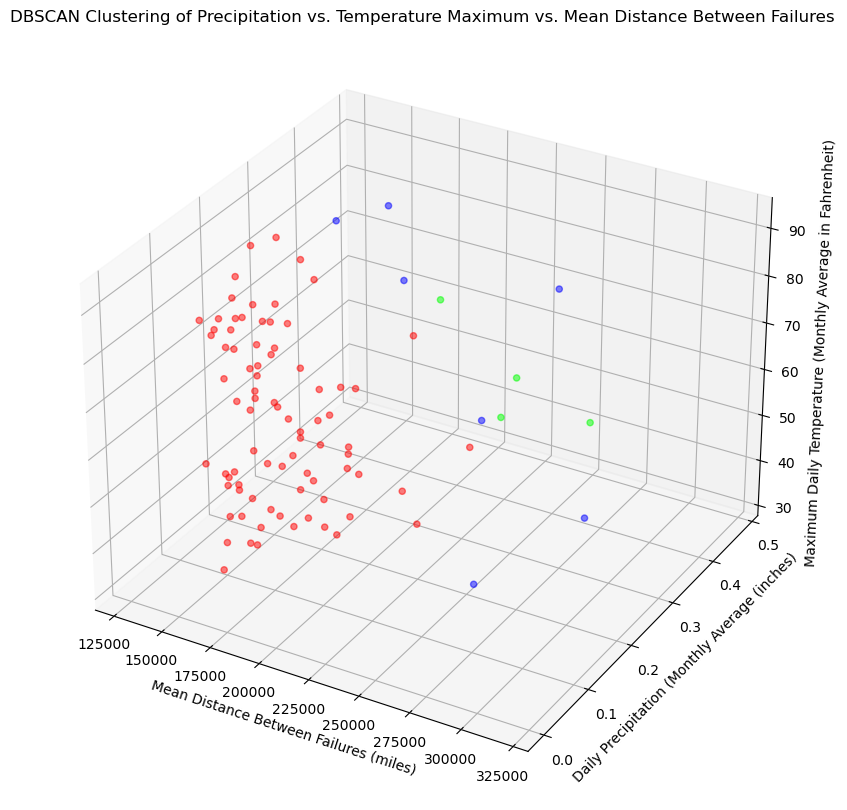

In [14]:
# Final DBSCAN model with parameters above
model = DBSCAN(eps=best_eps,min_samples=int(best_min_samples))
y_dbscan = model.fit_predict(X)
labels = model.labels_

u_X = scaler.inverse_transform(X)
# Plot clusters
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(u_X[:,0], u_X[:,1],u_X[:,2], c=y_dbscan, cmap="brg",alpha=0.5)
ax.set_title("DBSCAN Clustering of Precipitation vs. Temperature Maximum vs. Mean Distance Between Failures")
ax.set_xlabel("Mean Distance Between Failures (miles)")
ax.set_zlabel("Maximum Daily Temperature (Monthly Average in Fahrenheit)")
ax.set_ylabel("Daily Precipitation (Monthly Average (inches)")
plt.savefig("../../501-project-website/images/CLUSTERING-DB-RESULTS.png")
plt.show()

The above plot shows the resulting clusters after constructing and applying a DBSCAN model with the best epsilon and minimum sample hyperparameters found via hyperparameter tuning earlier in this document. Please note that the blue points are noise points, or "outliers" of sorts that are not associated with any cluster. This means that these points are not within the epsilon value (in terms of distance) from the clusters pictured in red and green. Ultimately, the most optimal DBSCAN model produces one huge cluster of low MDBF months with variable precipitation averages and maximum daily temperatures. The green cluster encompasses some of the high average daily precipitation months with variable MDBF and medium-low maximim daily temperatures. Overall, this method does not seem to produce particularly interesting or useful clusters given the assignment of the vast majority of data points to one cluster, while the second only contains four points.

# Hierarchical Clustering

## Hyperparameter Tuning

As described earlier, two important parameters for hierarchical clustering are the number of clusters to be created, and the linkage method used to build up the agglomerative clustering dendrogram. The optimal number of clusters for HC is dependent upon the linkage method used. Using various linkage methods, the distance between clusters are calculated and depicted in the dendrograms below. In this project, five different linkage methods were tested: Ward's, UPGMA, WPGMA, complete, and single.

Ward's method minimizes intra-cluster variance by minimizing the increase in intra-cluster variance when two points are merged in the dendrogram. This process is applied recursively from when each data point is a cluster to the top of the dendrogram. UPGMA (unweighted pair group method with arithmetic mean) finds inter-cluster distances by representing the structure of a pairwise simliarity matrix. WPGMA is the weighted counterpart of UPGMA, and produces a similar output. For these two methods, nearby clusters are combined to together to form the branches in the dendrogram. The complete method calculates inter-cluster distance by computing the difference between a given cluster and its furthest neighbor. At each step of the agglomerative process, the two nearest clusters are combined, and this process continues recursively until the whole dendrogram structure is created. Finally, the single linkage method is the most simple, also combining clusters recursively based on the nearest neighbor, while computing inter-cluster difference by simply comparing a given cluster with its nearest neighbor.

Each of the dendrograms for these methods are constructed and depicted below, and the ideal number of clusters in each dendrogram is extracted from the number of vertical lines where the longest vertical line from the top of the tree structure can be split without crossing a horizontal line. This is boundary is depicted by the red line in each dendrogram.

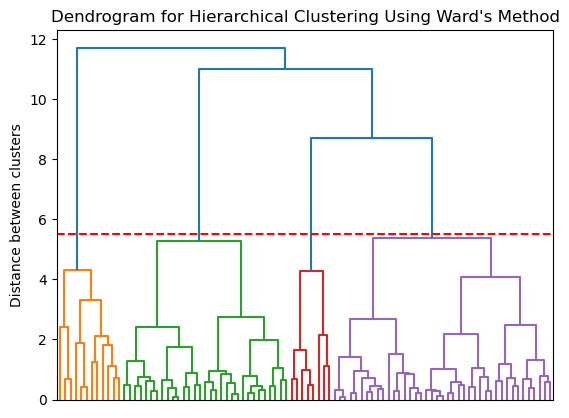

The optimal number of clusters based on the Ward's method dendrogram is 4


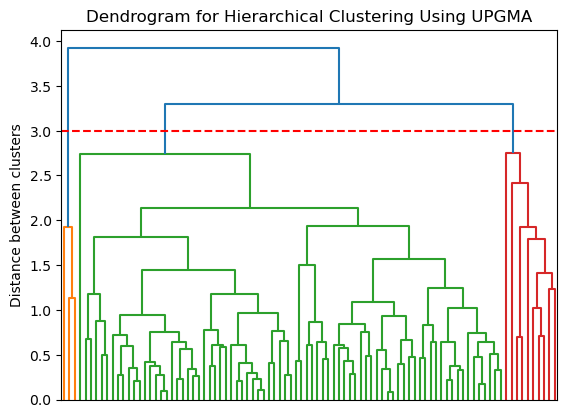

The optimal number of clusters based on the UPGMA dendrogram is 3


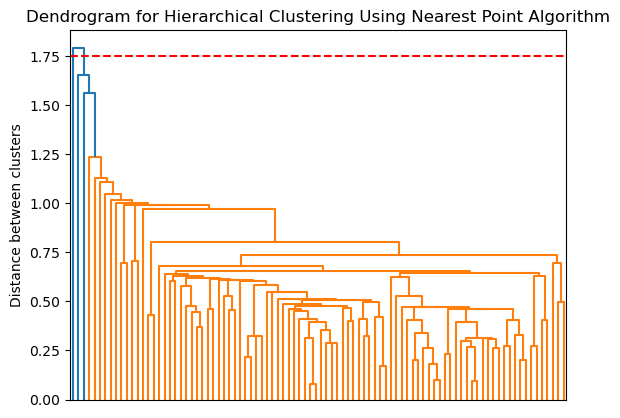

The optimal number of clusters based on the Nearest Point dendrogram is 2


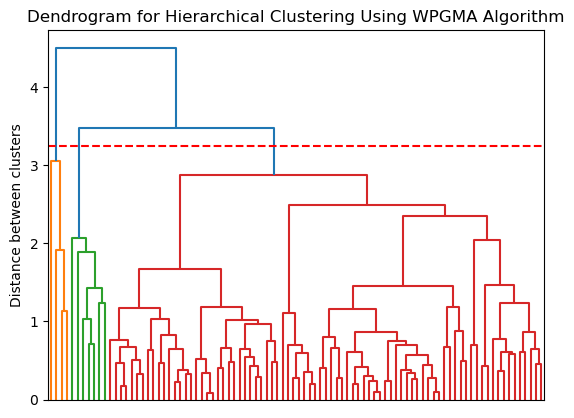

The optimal number of clusters based on the WPGMA dendrogram is 3


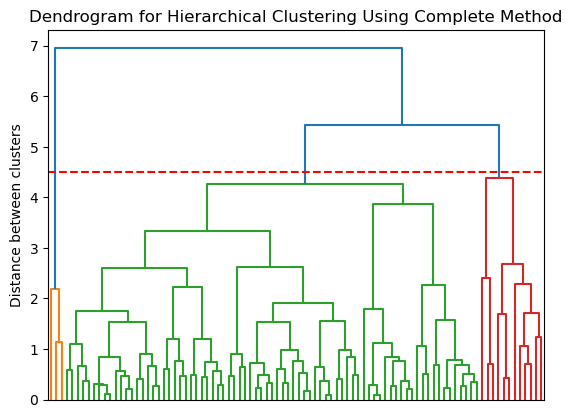

The optimal number of clusters based on the complete method dendrogram is 3


In [15]:
# Plot Ward's Method Dendrogram
fig,ax = plt.subplots()
Z = linkage(X, method='ward') 
dendro = dendrogram(Z)
plt.axhline(y=5.5, color='r', linestyle='--', label='5.5')
ax.set_title("Dendrogram for Hierarchical Clustering Using Ward's Method")
ax.set_xticklabels([])
ax.set_ylabel("Distance between clusters")
plt.savefig("../../501-project-website/images/CLUSTERING-HC-Ward.png")
plt.show()
print("The optimal number of clusters based on the Ward's method dendrogram is 4")

# Plot average method dendrogram
fig,ax = plt.subplots()
Z = linkage(X, method='average') 
dendro = dendrogram(Z)
plt.axhline(y=3, color='r', linestyle='--', label='3')
ax.set_title("Dendrogram for Hierarchical Clustering Using UPGMA")
ax.set_xticklabels([])
ax.set_ylabel("Distance between clusters")
plt.savefig("../../501-project-website/images/CLUSTERING-HC-upgma.png")
plt.show()
print("The optimal number of clusters based on the UPGMA dendrogram is 3")

# Plot single method dendrogram
fig,ax = plt.subplots()
Z = linkage(X, method='single') 
dendro = dendrogram(Z)
plt.axhline(y=1.75, color='r', linestyle='--', label='1.75')
ax.set_title("Dendrogram for Hierarchical Clustering Using Nearest Point Algorithm")
ax.set_xticklabels([])
ax.set_ylabel("Distance between clusters")
plt.savefig("../../501-project-website/images/CLUSTERING-HC-single.png")
plt.show()
print("The optimal number of clusters based on the Nearest Point dendrogram is 2")

# Plot weighted method dendrogram
fig,ax = plt.subplots()
Z = linkage(X, method='weighted') 
dendro = dendrogram(Z)
plt.axhline(y=3.25, color='r', linestyle='--', label='3.25')
ax.set_title("Dendrogram for Hierarchical Clustering Using WPGMA Algorithm")
ax.set_xticklabels([])
ax.set_ylabel("Distance between clusters")
plt.savefig("../../501-project-website/images/CLUSTERING-HC-wpgma.png")
plt.show()
print("The optimal number of clusters based on the WPGMA dendrogram is 3")

# Plot Complete Method Dendrogram
fig,ax = plt.subplots()
Z = linkage(X, method='complete') 
dendro = dendrogram(Z)
plt.axhline(y=4.5, color='r', linestyle='--', label='4.5')
ax.set_title("Dendrogram for Hierarchical Clustering Using Complete Method")
ax.set_xticklabels([])
ax.set_ylabel("Distance between clusters")
plt.savefig("../../501-project-website/images/CLUSTERING-HC-complete.png")
plt.show()
print("The optimal number of clusters based on the complete method dendrogram is 3")

The above dendrograms summarize the structure that each hierarchical clustering linkage method produces, along with accompanying ideal cluster numbers for each dendrogram printed below. Since one of the objectives of clustering is to maximize inter-cluster differences, the method that produces an optimal cluster number with the highest distance between clusters is the ideal linkage method. In these dendrograms above, Ward's method has the highest inter-cluster distance, and thus is the chosen linkage method along with its associated optimal cluster number of 4 for the final model. That model is constructed, visualized, and analyzed below.

## Result of Hierarchical Clustering

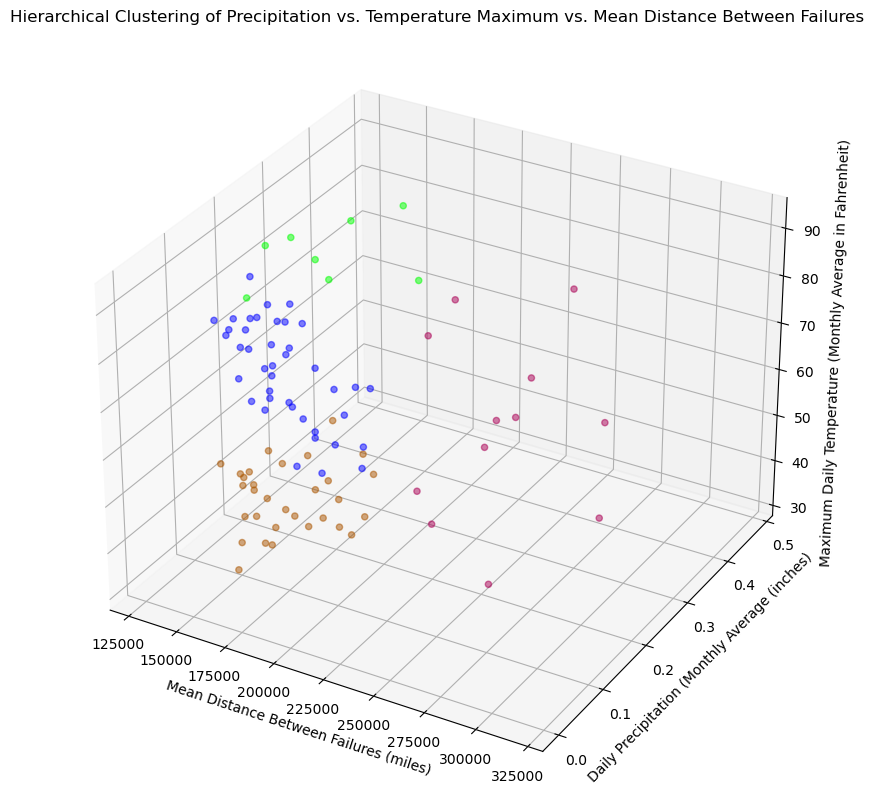

In [16]:
model = AgglomerativeClustering(n_clusters=4,linkage="ward").fit(X)
labels = model.labels_
y_hac = model.fit_predict(X)

u_X = scaler.inverse_transform(X)
# Plot clusters
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(u_X[:,0], u_X[:,1],u_X[:,2], c=y_hac, cmap="brg",alpha=0.5)
ax.set_title("Hierarchical Clustering of Precipitation vs. Temperature Maximum vs. Mean Distance Between Failures")
ax.set_xlabel("Mean Distance Between Failures (miles)")
ax.set_zlabel("Maximum Daily Temperature (Monthly Average in Fahrenheit)")
ax.set_ylabel("Daily Precipitation (Monthly Average (inches)")
plt.savefig("../../501-project-website/images/CLUSTERING-HC-RESULTS.png")
plt.show()

The HC method with ideal parameters determined above produce clusters very similar to those produced by the k-means clustering. However, the cluster towards the top of the scatterplot (green in this plot) is smaller than that created by the k-means algorithm. Overall, this method appears to be clearly delineate these data into appropriate clusters, and thus is an effective method as to clustering these data.

## Overall Results

As can be seen from the accompanying scatterplots for each clustering algorithm, the DBSCAN algorithm appears to be the least suitable for these data, relative to the hierarchical agglomerative and k-means clustering. The DBSCAN method did not produce particularly useful or interesting clusters given by the one huge cluster compared to the second miniscule cluster. Both the HC and k-means clustering algorithms produce relatively similar cluster delineations, so neither method is significantly better than the other when applied to these data. We can see through this clustering that there is an abundance of low MDBF values in the data while high MDBF months have very variable monthly average maximimum temperatures and levels of precipitation. Thus, it seems as if temperature and precipitation values do not have a significant correlation with changes in mean distance between failures given by the in-cluster variation among data points with different MDBF values. Unfortunately, there were no labels in the data set that could have been used to assess how closely these clusters model are associated with a hypothetical label. Thus, this analysis does not seem to provide any significant new revelation with regard to weather phenomena versus mean distance between failures. Further analyses could find more significant trends between these measures, and others as desired.

## Conclusions

Ultimately, it was apparent that the hierarchical and k-means clustering algorithsm were most well-suited to these data. Most months have relatively low mean distance between failures, meaning on average, the average distance between failures is roughly 150000 miles for a given subway train. Although this analysis did not provide any significant new insights into the potential connection between weather and NYC subway service reliability, it is still interesting and useful to apply these methods to these data to see if any relationships/correlations did, in fact, exist.

Further analyses should be undertaken to assess other new insights into the data, potentially incorporating other measures of NYC Subway performance and/or weather phenomena, or explore other natural barriers/effects that may affect the NYC Subway system. This could include examining on time performance (when data for that becomes available), how often trains need to be taken out of service, as well as weather phenomena such as humidity, snowfall, and wind, among others. There are countless possibilities that could further explore this potential connection between subway performance/reliability and natural phenomena. In short, more analysis needs to be done before establishing a connection between subway reliability and nature.

## References

1. Wikipedia contributors. "New York City Subway stations." Wikipedia, The Free Encyclopedia. Wikipedia, The Free Encyclopedia, 25 Oct. 2022. Web. 13 Nov. 2022. https://en.wikipedia.org/wiki/New_York_City_Subway_stations
2. Metropolitan Transit Authority. "MTA Subway Mean Distance Between Failures: Beginning 2015." Data.NY.gov, 26 Sept. 2022. Web. 13 Nov 2022. "https://data.ny.gov/Transportation/MTA-Subway-Mean-Distance-Between-Failures-Beginnin/e2qc-xgxs.